In [1]:
# Imports
import pandas as pd
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import re
from nltk.corpus import stopwords
import nltk
from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from torch.nn.functional import softmax
import torch
from sklearn.metrics import confusion_matrix, accuracy_score
import seaborn as sns



/opt/homebrew/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# 1. Exploration

In [2]:
# Read the CSV file into pandas dataframe
df = pd.read_csv("content/News_AI.csv", encoding='latin1')
df.head()

,Unnamed: 0,title,outlet,date,body
0,0,Biden leads US tech execs in Vietnam talks,Agence France Presse,2023-09-11,US President Joe Biden and senior executives f...
1,1,Tencent claims new AI chat bot skills comparab...,Agence France Presse,2023-09-07,Chinese tech giant Tencent on Thursday claimed...
2,2,Putin orders state support for AI as race heat...,Agence France Presse,2023-09-07,Russian President Vladimir Putin has ordered h...
3,3,UAE vows 'responsible' artificial intelligence...,Agence France Presse,2022-04-27,The world's first minister for artificial inte...
4,4,"Hollywood CEOs, striking writers at impasse af...",Agence France Presse,2023-08-23,The latest meeting between Hollywood's strikin...


In [3]:
# Find NaN values
print(df.isnull().sum())
print(len(df))

Unnamed: 0    0
title         0
outlet        0
date          0
body          2
dtype: int64
23689


In [4]:
# List unique outlets
unique_outlets = df['outlet'].unique()
print(unique_outlets)

['Agence France Presse' 'Straits_Times' 'Arab Digest' 'VentureBeat'
 'Canadian Press' 'Forbes.com' 'The Associated Press' 'CNN Wire'
 'THE KOREAN HERALD' 'China Daily' 'The Guardian (London)'
 'Times of India' 'The New York Times' 'TechRadar (UK)'
 'Public Papers of the Presidents' 'South China Morning Post']


In [5]:
# Convert the date column to datetime
df['date'] = pd.to_datetime(df['date'])
# Find the range of the date column
date_range = (df['date'].min(), df['date'].max())
print(f"Date Range: {date_range[0]} to {date_range[1]}")

Date Range: 2022-01-01 00:00:00 to 2024-05-08 00:00:00


In [6]:
# Combine title and body
df['title_body'] = df['title'] + ' ' + df['body']

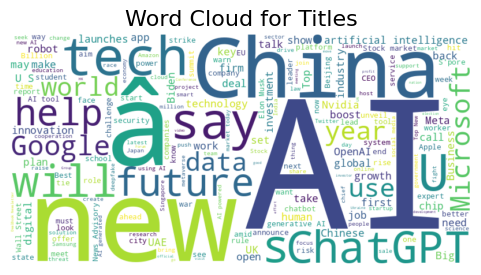

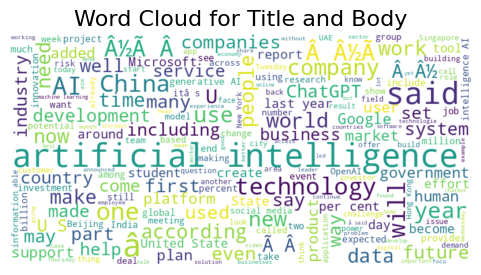

In [10]:
def plot_wordcloud(dataframe, column_name, title):
    # Combine all text from the specified column
    text = " ".join(text for text in dataframe[column_name].astype(str))
    
    # Generate the wordcloud
    wordcloud = WordCloud(width=800, height=400, background_color="white", colormap="viridis").generate(text)
    
    # Plot the wordcloud
    plt.figure(figsize=(6, 3))
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    plt.title(title, fontsize=16)
    plt.show()

# Wordcloud for both 'title' and 'title_body'
plot_wordcloud(df, 'title', 'Word Cloud for Titles')
plot_wordcloud(df, 'title_body', 'Word Cloud for Title and Body')


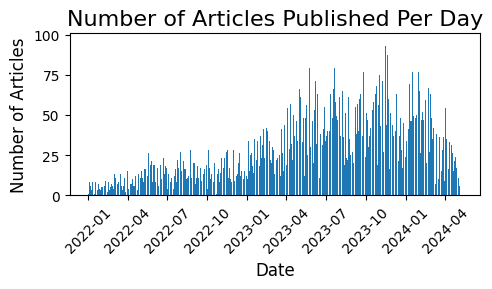

In [ ]:
daily_counts = df.groupby('date').size()

# Plot the histogram
plt.figure(figsize=(5, 3))
plt.bar(daily_counts.index, daily_counts.values)
plt.xlabel("Date", fontsize=12)
plt.ylabel("Number of Articles", fontsize=12)
plt.title("Number of Articles Published Per Day", fontsize=16)
plt.xticks(rotation=45, fontsize=10)  # Rotate date labels for better visibility
plt.tight_layout()
plt.show()

# 2. Preprocessing

In [7]:
# Download necessary NLTK components
nltk.download('stopwords')
nltk.download('wordnet')

# Initialize stopwords and lemmatizer
stop_words = set(stopwords.words('english'))

# Preprocessing function 
def preprocess_text(text):
    text = str(text)
    # Remove URLs
    text = re.sub(r'http\S+|www\.\S+', '', text)
    # Remove non-alphanumeric characters (excluding spaces)
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    # Remove extra whitespacess
    text = re.sub(r'\s+', ' ', text).strip()
    # Tokenize and remove stopwords
    tokens = text.split()
    filtered_tokens = [word for word in tokens if word not in stop_words]
    return ' '.join(filtered_tokens)

# Apply preprocessing to the column 'title' and 'title_body'
df['clean_title'] = df['title'].apply(preprocess_text)
df['clean_title_body'] = df['title_body'].apply(preprocess_text)

[nltk_data] Downloading package stopwords to /Users/bob/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /Users/bob/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


### 2.1 Filtering the dataset to get only AI relevant content

We filtered the data based on the clean_title_body column because we wanted to leverage as much information as possible to filter AI relevant content.

/opt/homebrew/lib/python3.11/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


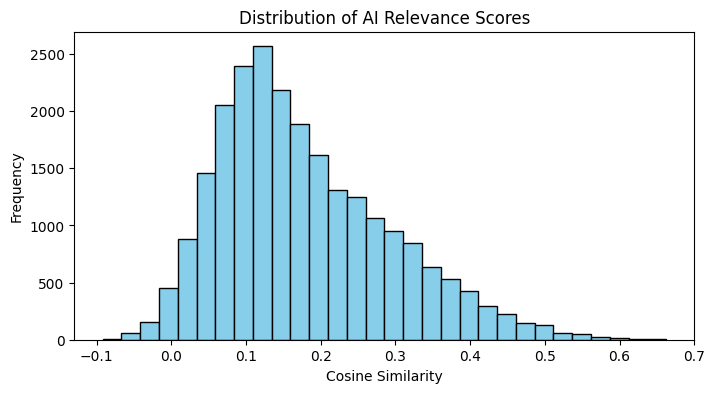

In [8]:
# Load the pre-trained sentencetransformer model
model = SentenceTransformer('all-MiniLM-L6-v2')

# Reference sentence (AI-related text to compare against)
ai_reference = """
Artificial Intelligence Machine Learning Deep Learning Neural Networks
Natural Language Processing ChatGPT OpenAI GPT-4 Chatbots Generative AI
Computer Vision Robotics Autonomous Large Language Models Algorithms Technology
"""

# Generate embeddings for the preprocessed title_body column and reference text
article_embeddings = model.encode(df['clean_title_body'].tolist())
ai_reference_embedding = model.encode([ai_reference])[0]

# Calculate cosine similarity between each article and the AI reference embedding and create new column 
cosine_similarities = cosine_similarity(article_embeddings, [ai_reference_embedding])
df['AI_relevance'] = cosine_similarities.flatten()

# Plot the distribution of the AI relevance scores
plt.figure(figsize=(8, 4))
plt.hist(df['AI_relevance'], bins=30, color='skyblue', edgecolor='black')
plt.title('Distribution of AI Relevance Scores')
plt.xlabel('Cosine Similarity')
plt.ylabel('Frequency')
plt.show()


Check how many remain relevant after setting a boundary. This boundary is based on a balance of only retaining
AI relevant articles but also on keeping enough data for reliable measurements. Also show the article with lowest score and the one with highest score.

In [9]:
# Set a boundary for the similarity scores and create new column
boundary = 0.15
df['AI_relevant'] = df['AI_relevance'] >= boundary

# Count how many articles remain as relevant
count = (df['AI_relevant'] == True).sum()
print(f"Number of times 'AI_relevant' is True: {count}")

# Get filtered_df based on AI relevance
filtered_df = df[df['AI_relevant'] == True]

# Find the row with the lowest AI_relevance score
lowest_relevance = df['AI_relevance'].min()
lowest_relevance_example = df[df['AI_relevance'] == lowest_relevance].iloc[0]['title_body']

# Find the row with the highest AI_relevance score
highest_relevance = df['AI_relevance'].max()
highest_relevance_example = df[df['AI_relevance'] == highest_relevance].iloc[0]['title_body']

# Print the examples
print("\nExample with the lowest AI_relevance score:")
print(f"AI_relevance score: {lowest_relevance}")
print(lowest_relevance_example)

print("\nExample with the highest AI_relevance score:")
print(f"AI_relevance score: {highest_relevance}")
print(highest_relevance_example)

Number of times 'AI_relevant' is True: 12280

Example with the lowest AI_relevance score:
AI_relevance score: -0.0920117199420929
5 things to know for Dec. 28: Border crisis, Ballot fight, Gaza, Holiday travel, (CNN) &#8212; If you feel as though you didn't read enough this year, don't fret. CNN asked a handful of 
2023's most relevant authors, musicians, and cultural tastemakers for book recommendations to help kick-start your 
2024 reading list.
Here's what else you need to know to Get Up to Speed and On with Your Day.
1. Border crisis
Top officials from the US and Mexico met on Wednesday to discuss the crisis at the southern border as the Biden 
administration scrambles to slow an unprecedented migrant surge. The meeting was "very productive," Secretary of 
Homeland Security Alejandro Mayorkas said, though it remains unclear which specific agreements were reached. 
Homeland Security officials have recently discussed a range of ways Mexico can help drive down numbers at the 
US borde

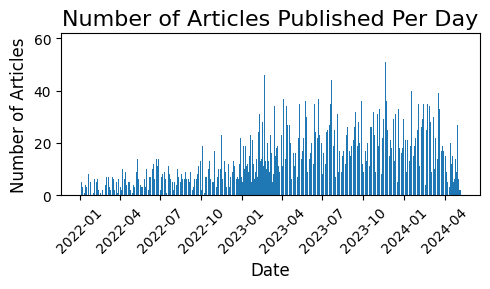

In [10]:
daily_counts_filtered = filtered_df.groupby('date').size()

# Plot the histogram
plt.figure(figsize=(5, 3))
plt.bar(daily_counts_filtered.index, daily_counts_filtered.values)
plt.xlabel("Date", fontsize=12)
plt.ylabel("Number of Articles", fontsize=12)
plt.title("Number of Articles Published Per Day", fontsize=16)
plt.xticks(rotation=45, fontsize=10)  # Rotate date labels for better visibility
plt.tight_layout()
plt.show()

### 2.2 Taking a sample to manually analyze dataset
In this step we are selecting a representative sample from this dataset, stratified by outlet, with a 95% confidence level and a 10% margin of error. This sample will be used for the manual categorization of titles in order to validate the methodologies and analyses used in the project.

In [26]:
# Calculate total population size
N = len(filtered_df)

# Function to calculate sample size with finite population correction
def calculate_sample_size(N, z=1.96, p=0.5, ME=0.1):
    n = (z**2 * p * (1 - p)) / (ME**2)
    n_adjusted = n / (1 + (n - 1) / N)
    return int(np.ceil(n_adjusted))

# Calculate the total sample size
sample_size = calculate_sample_size(N)
print(sample_size)

96


In [27]:
# Proportion per group
frac_per_group = sample_size / len(filtered_df)

# Stratified by outlet and date
stratified_sample = (
    filtered_df.groupby(['outlet'], group_keys=False)
    .filter(lambda x: len(x) > 1)
    .apply(lambda x: x.sample(frac=frac_per_group, random_state=42)) # FOR REPRODUCIBILITY
)
print(stratified_sample.head())
print(f"Sample size: {len(stratified_sample)}")

       Unnamed: 0                                              title  \
10819       10819  Jon Stewart on AI: âItâs replacing us in t...   
4189         4189  How to use data analytics to improve quality o...   
664           664  Meta wants industry-wide labels for AI-made im...   
12873       12873          âAI may also monitor voting machinesâ   
11501       11501  AI canât compete with the likes of Taylor Swift   

                      outlet       date  \
10819  The Guardian (London) 2024-04-02   
4189             VentureBeat 2022-04-23   
664     Agence France Presse 2024-02-06   
12873         Times of India 2024-03-18   
11501  The Guardian (London) 2023-05-22   

                                                    body  \
10819  Late-night hosts talked the promise and perils...   
4189   Apr 23, 2022( VentureBeat: http://venturebeat....   
664    Meta on Tuesday said it is working with other ...   
12873  Dance of Democracy\nKolkata: With the number o...   
11501  T

In [28]:
# Range of the sample
date_range = (stratified_sample['date'].min(), stratified_sample['date'].max())
print(f"Date Range: {date_range[0]} to {date_range[1]}")

Date Range: 2022-01-28 00:00:00 to 2024-04-26 00:00:00


In [29]:
stratified_sample.head()

,Unnamed: 0,title,outlet,date,body,title_body,clean_title,clean_title_body,AI_relevance,AI_relevant
10819,10819,Jon Stewart on AI: âItâs replacing us in t...,The Guardian (London),2024-04-02,Late-night hosts talked the promise and perils...,Jon Stewart on AI: âItâs replacing us in t...,Jon Stewart AI Its replacing us workforce future,Jon Stewart AI Its replacing us workforce futu...,0.286941,True
4189,4189,How to use data analytics to improve quality o...,VentureBeat,2022-04-23,"Apr 23, 2022( VentureBeat: http://venturebeat....",How to use data analytics to improve quality o...,How use data analytics improve quality life,How use data analytics improve quality life Ap...,0.201327,True
664,664,Meta wants industry-wide labels for AI-made im...,Agence France Presse,2024-02-06,Meta on Tuesday said it is working with other ...,Meta wants industry-wide labels for AI-made im...,Meta wants industrywide labels AImade images,Meta wants industrywide labels AImade images M...,0.283753,True
12873,12873,âAI may also monitor voting machinesâ,Times of India,2024-03-18,Dance of Democracy\nKolkata: With the number o...,âAI may also monitor voting machinesâ Danc...,AI may also monitor voting machines,AI may also monitor voting machines Dance Demo...,0.284716,True
11501,11501,AI canât compete with the likes of Taylor Swift,The Guardian (London),2023-05-22,Thereâs a lot of noise from musicians about ...,AI canât compete with the likes of Taylor Sw...,AI cant compete likes Taylor Swift,AI cant compete likes Taylor Swift Theres lot ...,0.245166,True


In [20]:
# CSV file
stratified_sample.to_csv('sample.csv', index=False)

# 3 Analysis of VADER and RoBERTa on titles

In [15]:
# Download the VADER lexicon
nltk.download('vader_lexicon')

# Initialize VADER Sentiment Analyzer
sia = SentimentIntensityAnalyzer()

# Function to classify sentiment into three categories
def get_sentiment_score(title):
    score = sia.polarity_scores(title)
    if score['compound'] >= 0.05:
        return 'positive'
    elif score['compound'] <= -0.05:
        return 'negative'
    else:
        return 'neutral'

# Apply the function to get sentiment assignments
filtered_df['sentiment_title_vader'] = filtered_df['clean_title'].apply(get_sentiment_score)
#filtered_df['sentiment_title_body_vader'] = filtered_df['clean_title_body'].apply(get_sentiment_score)


[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/bob/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
/var/folders/99/5zk2d78d581cfzrc4jp1bzqc0000gn/T/ipykernel_66055/166052468.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['sentiment_title_vader'] = filtered_df['clean_title'].apply(get_sentiment_score)


In [16]:
# For mac else use cuda
device = torch.device("mps") if torch.backends.mps.is_available() else torch.device("cpu")

# Load the model and tokenizer
model_name = "cardiffnlp/twitter-roberta-base-sentiment"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name)
model = model.to(device)

# Function to classify sentiment into three categories
def get_sentiment(text):
    inputs = tokenizer(text, return_tensors="pt", truncation=True, max_length=512).to(device)
    outputs = model(**inputs)
    probs = softmax(outputs.logits, dim=-1)
    sentiment_map = {0: 'negative', 1: 'neutral', 2: 'positive'}
    sentiment = torch.argmax(probs, dim=1).item()
    return sentiment_map[sentiment]

# Apply the function to get sentiment assignments
filtered_df['sentiment_title_bert'] = filtered_df['clean_title'].apply(get_sentiment)
#filtered_df['sentiment_title_body_bert'] = filtered_df['clean_title_body'].apply(get_sentiment)

/var/folders/99/5zk2d78d581cfzrc4jp1bzqc0000gn/T/ipykernel_66055/1540742224.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['sentiment_title_bert'] = filtered_df['clean_title'].apply(get_sentiment)


<Figure size 600x300 with 0 Axes>

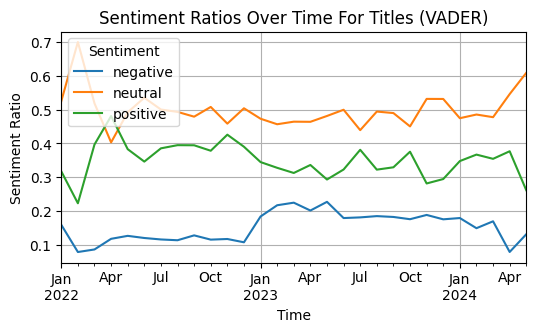

<Figure size 600x300 with 0 Axes>

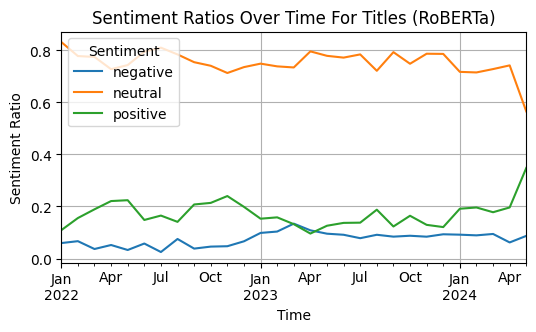

In [17]:
def plot_sentiment_ratios(dataframe, sentiment_column, title):
    """
    Function to group sentiment counts by month, calculate sentiment ratios and plot them.
    
    Args:
    - dataframe (pd.DataFrame): The DataFrame containing the sentiment data.
    - sentiment_column (str): The column name for sentiment data.
    - title (str): The title of the plot.
    """
    # Group by month and calculate sentiment counts
    sentiment_counts = dataframe.groupby(pd.Grouper(key='date', freq='M'))[sentiment_column].value_counts().unstack(fill_value=0)
    
    # Calculate sentiment ratios
    sentiment_ratios = sentiment_counts.div(sentiment_counts.sum(axis=1), axis=0)
    
    # Plot sentiment ratios
    plt.figure(figsize=(6, 3))
    sentiment_ratios.plot(kind='line', title=title, figsize=(6, 3))
    plt.ylabel('Sentiment Ratio')
    plt.xlabel('Time')
    plt.legend(title='Sentiment', loc='upper left')
    plt.grid()
    plt.show()

# Plot for VADER on titles
plot_sentiment_ratios(filtered_df, 'sentiment_title_vader', 'Sentiment Ratios Over Time For Titles (VADER)')

# Plot for VADER on titles + body
#plot_sentiment_ratios(filtered_df, 'sentiment_title_body_vader', 'Sentiment Ratios Over Time For Title + Body (VADER)')

# Plot for RoBERTa on titles
plot_sentiment_ratios(filtered_df, 'sentiment_title_bert', 'Sentiment Ratios Over Time For Titles (RoBERTa)')

# Plot for RoBERTa on titles + body
#plot_sentiment_ratios(filtered_df, 'sentiment_title_body_bert', 'Sentiment Ratios Over Time For Title + Body (RoBERTa)')


# 4. Model Evaluation

Multiple annotator agreement accuracy and model consistency 

In [28]:
# Importing manual annotation dataset
df_validation = pd.read_csv("content/Validation_Data.csv")
df_validation.head()

,Unnamed: 0,outlet,date,title,Bob,Kalenga,Isabela,Emma,Score,count negative,count positive,count neutral
0,10819,The Guardian (London),2024-04-02,Jon Stewart on AI: ‘It’s replacing us in the w...,Negative,Negative,Negative,Negative,negative,4,0,0
1,4189,VentureBeat,2022-04-23,How to use data analytics to improve quality o...,Positive,Positive,Positive,Positive,positive,0,4,0
2,664,Agence France Presse,2024-02-06,Meta wants industry-wide labels for AI-made im...,Neutral,Positive,Neutral,Neutral,neutral,0,1,3
3,12873,Times of India,2024-03-18,‘AI may also monitor voting machines’,Neutral,Positive,Neutral,Neutral,neutral,0,1,3
4,11501,The Guardian (London),2023-05-22,AI can’t compete with the likes of Taylor Swift,Negative,Neutral,Neutral,Negative,neutral,2,0,2


In [29]:
merged_df = pd.merge(filtered_df, df_validation, on='Unnamed: 0', how='inner')
y_true = merged_df['Score']

# Calculate accuracy for VADER only title
y_pred_vader = merged_df['sentiment_title_vader']
accuracy_vader = accuracy_score(y_true, y_pred_vader)

# Calculate accuracy for VADER title+body
#y_pred_vader_tb = merged_df['sentiment_title_body_vader']
#accuracy_vader_tb = accuracy_score(y_true, y_pred_vader_tb)

# Calculate accuracy for BERT only title
y_pred_bert = merged_df['sentiment_title_bert']
accuracy_bert = accuracy_score(y_true, y_pred_bert)

# Calculate accuracy for BERT title+body
#y_pred_bert_tb = merged_df['sentiment_title_body_bert']
#accuracy_bert_tb = accuracy_score(y_true, y_pred_bert_tb)

# Create a table with the accuracies
accuracy_data = {
    'Model': ['VADER Headline', 'RoBERTa Headline'],
    'Accuracy': [round(accuracy_vader * 100, 1), round(accuracy_bert * 100, 1)]
}

# Convert the data into a DataFrame
accuracy_df = pd.DataFrame(accuracy_data)
accuracy_df


,Model,Accuracy
0,VADER Headline,54.2
1,RoBERTa Headline,72.9


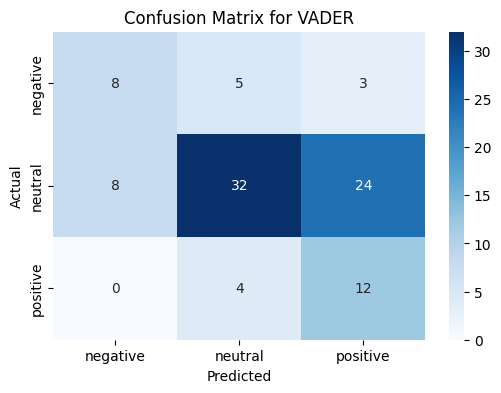

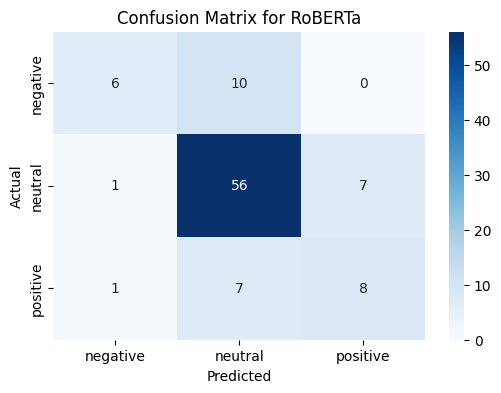

In [35]:
# Map sentiments to numerical values 
sentiment_mapping = {'negative': 0, 'neutral': 1, 'positive': 2}
manual_values = merged_df['Score'].map(sentiment_mapping)
vader_values = merged_df['sentiment_title_vader'].map(sentiment_mapping)
bert_values = merged_df['sentiment_title_bert'].map(sentiment_mapping)

# Calculate confusion matrix
conf_matrix_vader = confusion_matrix(manual_values, vader_values)
conf_matrix_bert = confusion_matrix(manual_values, bert_values)

def plot_confusion_matrix(matrix, title):
    plt.figure(figsize=(6, 4))
    sns.heatmap(matrix, annot=True, fmt='d', cmap='Blues', xticklabels=sentiment_mapping.keys(), yticklabels=sentiment_mapping.keys())
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title(title)
    plt.show()

# Plot confusion matrices
plot_confusion_matrix(conf_matrix_vader, 'Confusion Matrix for VADER')
plot_confusion_matrix(conf_matrix_bert, 'Confusion Matrix for RoBERTa')



/var/folders/99/5zk2d78d581cfzrc4jp1bzqc0000gn/T/ipykernel_24616/2023513691.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['sentiment_title_bert_num'] = filtered_df['sentiment_title_bert'].map(sentiment_mapping)
/var/folders/99/5zk2d78d581cfzrc4jp1bzqc0000gn/T/ipykernel_24616/2023513691.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['sentiment_title_vader_num'] = filtered_df['sentiment_title_vader'].map(sentiment_mapping)


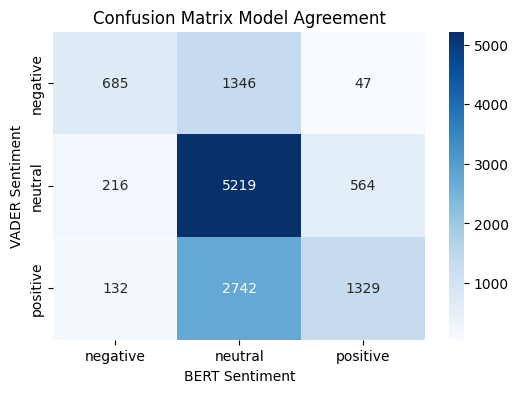

Consistency Score: 0.59


In [36]:
# Map sentiments to numerical values
filtered_df['sentiment_title_bert_num'] = filtered_df['sentiment_title_bert'].map(sentiment_mapping)
filtered_df['sentiment_title_vader_num'] = filtered_df['sentiment_title_vader'].map(sentiment_mapping)

# Calculate confusion matrix
conf_matrix = confusion_matrix(
    filtered_df['sentiment_title_vader_num'], 
    filtered_df['sentiment_title_bert_num']
)

# Plot the confusion matrix
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=sentiment_mapping.keys(), yticklabels=sentiment_mapping.keys())
plt.xlabel('BERT Sentiment')
plt.ylabel('VADER Sentiment')
plt.title('Confusion Matrix Model Agreement')
plt.show()

# Calculate consistency score (accuracy)
consistency_score = accuracy_score(
    filtered_df['sentiment_title_vader_num'], 
    filtered_df['sentiment_title_bert_num']
)

print(f"Consistency Score: {consistency_score:.2f}")


# 5. Zooming in on the launch of ChatGPT

Here we investigate the difference in positive and negative sentiment on headlines with RoBERTa from before and after the launch of ChatGPT (30 nov 2022)

<Figure size 600x300 with 0 Axes>

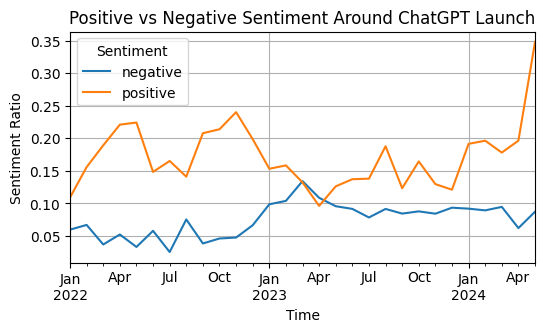

In [ ]:
# Absolute sentiment counts
sentiment_counts = filtered_df.groupby(pd.Grouper(key='date', freq='M'))['sentiment_title_bert'].value_counts().unstack(fill_value=0)
    
# Calculate sentiment ratios
sentiment_ratios = sentiment_counts.div(sentiment_counts.sum(axis=1), axis=0)

# Only plot the positive and negative sentiment
sentiment_ratios = sentiment_ratios[['negative', 'positive']]

# Plot sentiment ratios
plt.figure(figsize=(6, 3))
sentiment_ratios.plot(kind='line', title='Positive vs Negative Sentiment Around ChatGPT Launch', figsize=(6, 3))
plt.ylabel('Sentiment Ratio')
plt.xlabel('Time')
plt.legend(title='Sentiment', loc='upper left')
plt.grid()


# 6. Sentiment for different countries

In [39]:
# Define a dictionary to map outlets to countries
outlet_to_country = {
    'Agence France Presse': 'France',
    'Straits_Times': 'Singapore',
    'Arab Digest': 'UK',
    'VentureBeat': 'USA',
    'Canadian Press': 'Canada',
    'Forbes.com': 'USA',
    'The Associated Press': 'USA',
    'CNN Wire': 'USA',
    'THE KOREAN HERALD': 'South Korea',
    'China Daily': 'China',
    'The Guardian (London)': 'UK',
    'Times of India': 'India',
    'The New York Times': 'USA',
    'TechRadar (UK)': 'UK',
    'Public Papers of the Presidents': 'USA',
    'South China Morning Post': 'China'
}

# Map the outlet names to the country column
filtered_df['country'] = filtered_df['outlet'].map(outlet_to_country)

# Count the number of articles per country
articles_per_country = filtered_df['country'].value_counts()

# Display the result
print(articles_per_country)

country
USA            4113
UK             2201
India          1832
China          1767
Singapore       698
Canada          629
France          620
South Korea     420
Name: count, dtype: int64


/var/folders/99/5zk2d78d581cfzrc4jp1bzqc0000gn/T/ipykernel_24616/53053538.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['country'] = filtered_df['outlet'].map(outlet_to_country)


<Figure size 600x300 with 0 Axes>

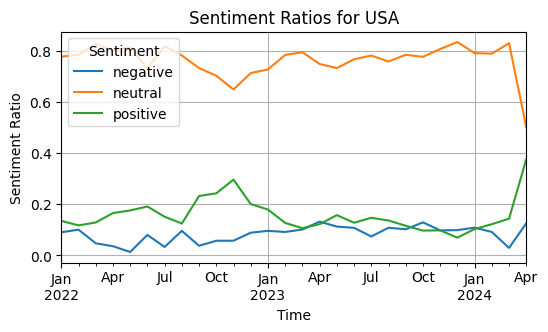

<Figure size 600x300 with 0 Axes>

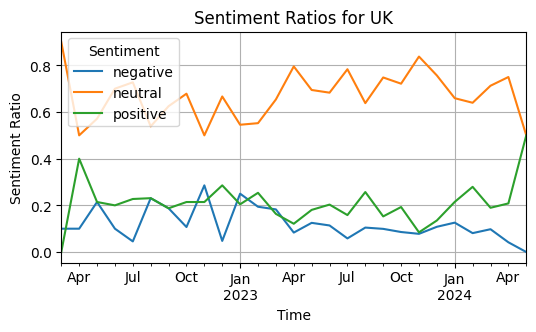

<Figure size 600x300 with 0 Axes>

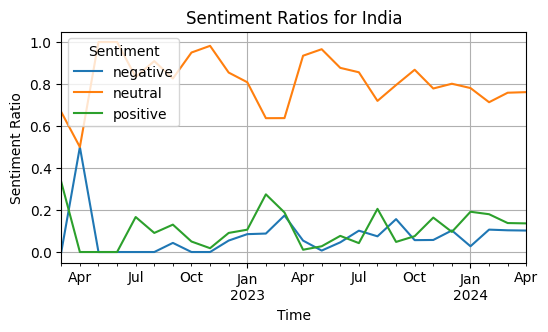

<Figure size 600x300 with 0 Axes>

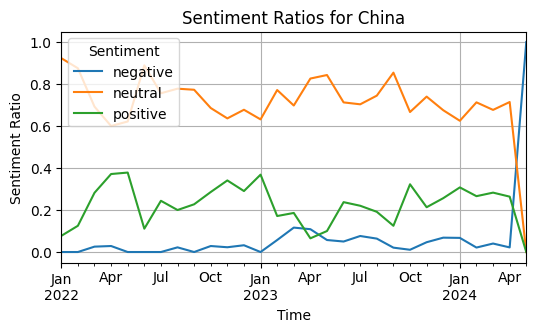

In [42]:
# Filter for the top 4 countries
top_4_countries = ['USA', 'UK', 'India', 'China']

# Loop through the top 4 countries and plot sentiment ratios for each
for country in top_4_countries:
    # Filter the DataFrame for the specific country
    country_df = filtered_df[filtered_df['country'] == country]
    
    # Plot the sentiment ratios
    plot_sentiment_ratios(country_df, 'sentiment_title_bert', f'Sentiment Ratios for {country}')


# 7. Looking into Sub-Topics

Use cosine similarites with topic reference texts and apply sentiment analysis with RoBERTa on titles

In [18]:
model = SentenceTransformer('all-MiniLM-L6-v2')

# Function to calculate cosine similarity and filter DataFrame
def filter_by_relevance(df, reference_text, boundary, relevance_col_name):
    # Generate embeddings for the articles
    article_embeddings = model.encode(df['clean_title_body'].tolist())
    # Generate embedding for the reference text
    reference_embedding = model.encode([reference_text])[0]
    # Calculate cosine similarity
    cosine_similarities = cosine_similarity(article_embeddings, [reference_embedding]).flatten()
    # Add similarity scores to the DataFrame
    df[relevance_col_name] = cosine_similarities
    # Filter based on the boundary and return all similarity scores
    return df[df[relevance_col_name] >= boundary], cosine_similarities

# Function to plot simimilarity distribution
def plot_similarity_distribution(similarities, relevance_col_name):
    plt.figure(figsize=(6, 3))
    plt.hist(similarities, bins=30, color='skyblue', edgecolor='black')
    plt.title(f'Distribution of {relevance_col_name} Scores')
    plt.xlabel('Cosine Similarity')
    plt.ylabel('Frequency')
    plt.show()

/opt/homebrew/lib/python3.11/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


/var/folders/99/5zk2d78d581cfzrc4jp1bzqc0000gn/T/ipykernel_66055/2274885314.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[relevance_col_name] = cosine_similarities


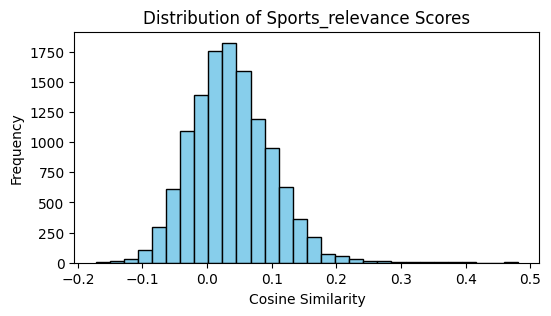

<Figure size 600x300 with 0 Axes>

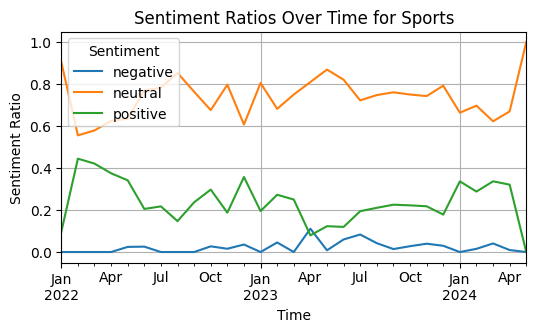

1864


In [19]:
# Process sports articles
sports_reference = """
    Sports Football Soccer Basketball Baseball Tennis Cricket Olympics
    Athletes Teams Matches Competitions World Cup Championships FIFA NBA
    Athletics Running Fitness Training Sporting Events Medals Records
"""

filtered_df_sports, sims_sports = filter_by_relevance(filtered_df, sports_reference, 0.1, 'Sports_relevance')
plot_similarity_distribution(sims_sports, 'Sports_relevance')
plot_sentiment_ratios(filtered_df_sports, 'sentiment_title_bert', 'Sentiment Ratios Over Time for Sports')
print(len(filtered_df_sports))

/var/folders/99/5zk2d78d581cfzrc4jp1bzqc0000gn/T/ipykernel_66055/2274885314.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[relevance_col_name] = cosine_similarities


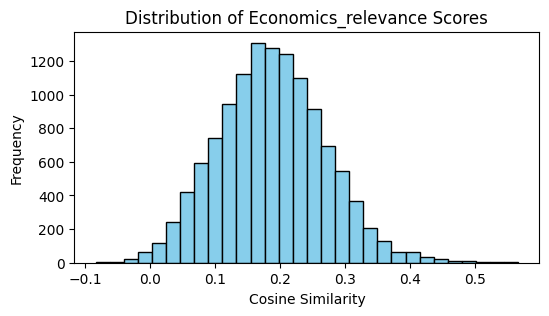

<Figure size 600x300 with 0 Axes>

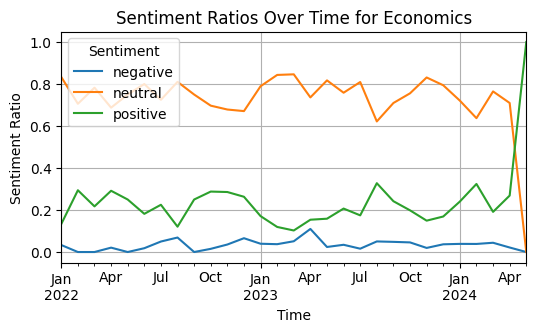

2723


In [20]:
# Process economics articles
economics_reference = """
    Finance Banking Investments Stocks Bonds Markets Securities
    Trading Risk Management Wealth Management Financial Planning
    Portfolio Diversification Mutual Funds Hedge Funds Private Equity
    Venture Capital Corporate Finance Budgeting Revenue Profit
    Cryptocurrency Blockchain Financial Technology Fintech Interest Rates
    Credit Loans Mortgages Inflation Exchange Rates Accounting Economics
"""

filtered_df_economics, sims_economics = filter_by_relevance(filtered_df, economics_reference, 0.25, 'Economics_relevance')
plot_similarity_distribution(sims_economics, 'Economics_relevance')
plot_sentiment_ratios(filtered_df_economics, 'sentiment_title_bert', 'Sentiment Ratios Over Time for Economics')
print(len(filtered_df_economics))


/var/folders/99/5zk2d78d581cfzrc4jp1bzqc0000gn/T/ipykernel_66055/2274885314.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[relevance_col_name] = cosine_similarities


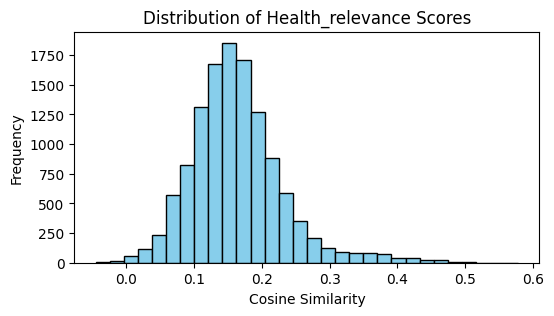

<Figure size 600x300 with 0 Axes>

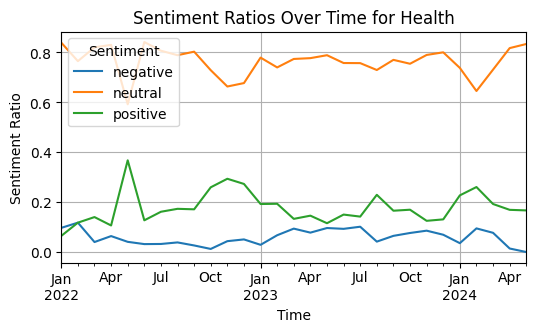

2869


In [22]:
# Process health articles
health_reference = """
    Health Medicine Healthcare Wellness Fitness Nutrition Exercise
    Disease Prevention Public Health Mental Health Chronic Illness
    Healthcare Systems Hospitals Clinics Vaccination Health Insurance
    Doctors Nurses Medical Professionals COVID-19 Pandemics Vaccines
    Therapy Surgery Treatment Diagnostics Pharmaceuticals
    Healthy Lifestyle Physical Activity Diet Rehabilitation Recovery
"""

filtered_df_health, sims_health = filter_by_relevance(filtered_df, health_reference, 0.2, 'Health_relevance')
plot_similarity_distribution(sims_health, 'Health_relevance')
plot_sentiment_ratios(filtered_df_health, 'sentiment_title_bert', 'Sentiment Ratios Over Time for Health')
print(len(filtered_df_health))


/var/folders/99/5zk2d78d581cfzrc4jp1bzqc0000gn/T/ipykernel_66055/2274885314.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[relevance_col_name] = cosine_similarities


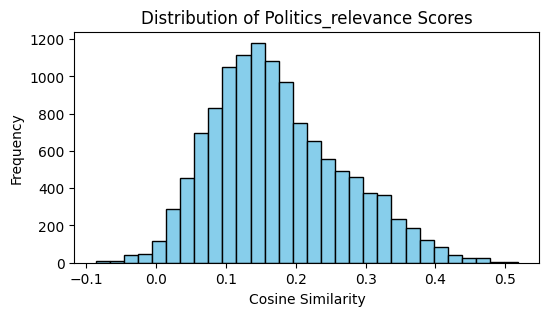

<Figure size 600x300 with 0 Axes>

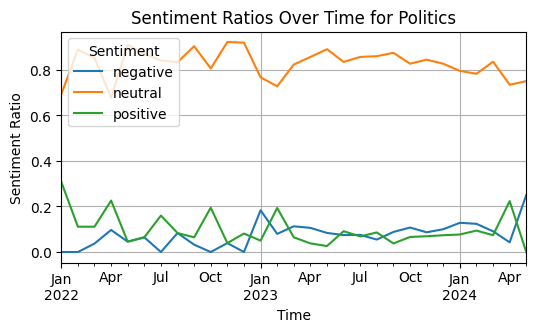

2613


In [24]:
# Process politics articles
politics_reference = """
    Politics Government Elections Democracy Policies Leaders Political Parties
    Legislation Parliament Congress Politicians Campaigns Debates Voting
    Public Administration National Security Foreign Policy International Relations
    Diplomacy War Peace Treaties Constitution Public Opinion Lawmaking
    Corruption Scandals Political Movements Human Rights Governance Authority
"""

filtered_df_politics, sims_politics = filter_by_relevance(filtered_df, politics_reference, 0.25, 'Politics_relevance')
plot_similarity_distribution(sims_politics, 'Politics_relevance')
plot_sentiment_ratios(filtered_df_politics, 'sentiment_title_bert', 'Sentiment Ratios Over Time for Politics')
print(len(filtered_df_politics))

/var/folders/99/5zk2d78d581cfzrc4jp1bzqc0000gn/T/ipykernel_66055/2274885314.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[relevance_col_name] = cosine_similarities


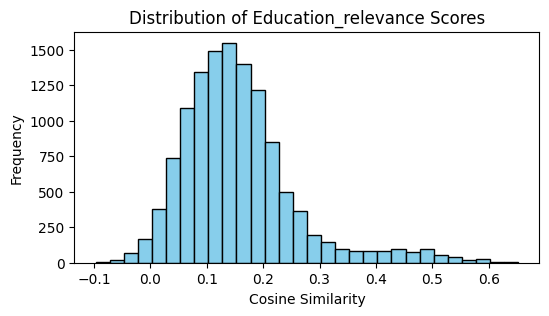

<Figure size 600x300 with 0 Axes>

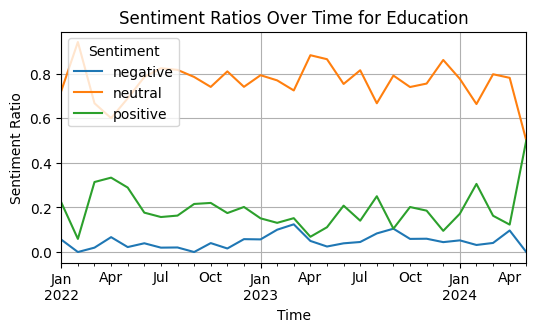

2938


In [25]:
# Process education articles
education_reference = """
    Education Schools University College Learning Students Teachers Curriculum
    Classes Exams Study Education System Pedagogy Graduation Degree Diploma
    Classroom Teaching Research Higher Education Distance Learning Online Learning
    Educational Policy Academic Institutions Knowledge Development Literacy
    Career Pathways Scholarships Education Technology EdTech Schooling
"""

filtered_df_education, sims_education = filter_by_relevance(filtered_df, education_reference, 0.2, 'Education_relevance')
plot_similarity_distribution(sims_education, 'Education_relevance')
plot_sentiment_ratios(filtered_df_education, 'sentiment_title_bert', 'Sentiment Ratios Over Time for Education')
print(len(filtered_df_education))